In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# SEIR model and mean field approximation 

In [2]:
alphaE=0.01
alphaI=0.08
alphaR=0.02
alphaL=0.01
alphaA=0.04
def computeK(m):
    K = np.zeros(shape=(4,4))
    K[0,1] = alphaE+alphaI*m[2];     K[0,0] = 1-K[0,1]
    K[1,2] = alphaA;                 K[1,1] = 1-K[1,2]
    K[2,3] = alphaR;                 K[2,2] = 1-K[2,3]
    K[3,0] = alphaL;                 K[3,3] = 1-K[3,0]
    for i in range(3):
        for j in range(3):
            if K[i,j] < 0 or K[i,j] > 1: 
                print('rate error: K[',i,j,']=',K[i,j])
    return(K)

m0 = np.array([1,0,0,0])

def simulate(m0,T):
    m=m0
    M=np.zeros(shape=(T,4))
    for t in range(T):
        m = np.tensordot(m,computeK(m),1)
        M[t,:] = m
    return(M)

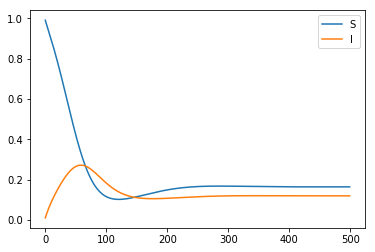

In [3]:
M = simulate(m0,500)
plt.plot(M[:,0])
plt.plot(M[:,1])
plt.legend(['S','I'])


# Refined mean field approximation 

In [4]:
def computeA(m):
    return(np.array([
        [1-(alphaE+alphaI*m[2]), 0,          -alphaI*m[0],  alphaL],
        [alphaE+alphaI*m[2],     1-alphaA,   alphaI*m[0],   0],
        [0,                      alphaA,     1-alphaR,      0],
        [0,                      0,          alphaR,        1-alphaL]]))
def computeB(m):
    B = np.zeros(shape=(4,4,4))
    B[0,0,2] = -alphaI
    B[0,2,0] = -alphaI
    B[1,0,2] = alphaI
    B[1,2,0] = alphaI
    return(B)
def computeGamma(m):
    G = np.zeros(shape=(4,4))
    K = computeK(m)
    for j in range(4):
        for k in range(4):
            if j==k: 
                G[j,k] = sum([m[i]*K[i,j]*(1-K[i,j]) for i in range(4)])
            else:
                G[j,k] = sum([m[i]*K[i,j]*(-K[i,k]) for i in range(4)])
    return(G)
    
def refinedMF(m0,T):
    m = m0
    v = np.zeros((4))
    w = np.zeros((4,4))
    
    M=[]
    V=[]
    W=[]
    
    for t in range(T):
        A = computeA(m)
        B = computeB(m)
        Gamma = computeGamma(m)
        
        M.append(m)
        
        v = np.dot(A,v) + np.tensordot(B,w,2)/2
        w = Gamma + np.dot(np.dot(A,w),np.transpose(A))
        m = np.tensordot(m,computeK(m),1)
        
        V.append(v)
        W.append(w)
        
    return(np.array(M),np.array(V),np.array(W))

M,V,W = refinedMF(m0,500)


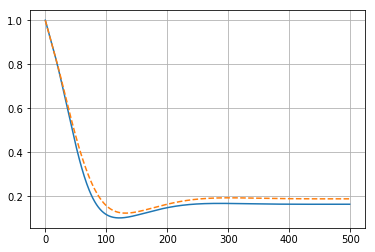

In [5]:
N=10
plt.plot(M[:,0])
plt.plot(M[:,0]+V[:,0]/N,'--')
plt.grid()
#plt.ylim([0,0.4])

In [6]:
print(M[-1,:])
print(M[-1,:] + V[-1,:]/N)

[0.16399148 0.11936619 0.23892306 0.47771927]
[0.1885441  0.1158525  0.23200904 0.46359436]


# Comparison with simulations 

Note : in order to avoid redoing the 50.000 simulations each time (which takes ~1h), the results are saved in a file. It is possible to force the program to recompute all simulation either by deleting this file or by using "forceRedoSimulation=True". 

In [7]:
import os 
import sys
import time

def simulate_MC(m0,T,N):
    m = m0
    M = []
    
    for t in range(T):
        M.append(m)
        K = computeK(m)
        newM = np.zeros(4)
        for i in range(4):
            newM += np.random.multinomial(int(N*m[i]), K[i,:], size=1).reshape(4)
        m = newM/N
    return(np.array(M))
def averageSimulation(m0,T,N,number_of_simulations,forceRedoSimulation=False):
    fileName = 'simu_SEIR_m{}_{}_{}_{}_N{}_T{}.npz'.format(int(m0[0]*1000),
                                                           int(m0[1]*1000),
                                                           int(m0[2]*1000),
                                                           int(m0[3]*1000),
                                                           N,
                                                           T)
    if os.path.isfile(fileName) and not forceRedoSimulation :
        data = np.load(fileName)
        alreadyDoneSimu = data['nbSimu']
        M = data['M']
    else:
        alreadyDoneSimu = 0
        M = np.zeros(shape=(T,len(m0)))
    if alreadyDoneSimu < number_of_simulations:
        for i in range(alreadyDoneSimu,number_of_simulations):
            M += simulate_MC(m0,T,N)
            print('\r{}/{}'.format(i,number_of_simulations),end='')
        np.savez(fileName,M=M,nbSimu=number_of_simulations)
    return(M/max(alreadyDoneSimu,number_of_simulations))

for numberSimu in range(0,50000,5000):
    # This code will generate 100000 simulation and saves the result each 5000 simulation (hence it can be interupted)
    Msimu = averageSimulation(m0,T=500,N=10,number_of_simulations=numberSimu)

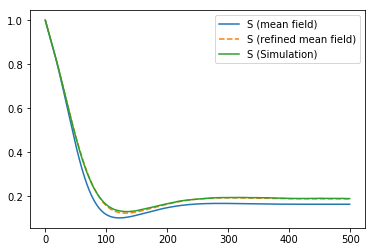

In [8]:
f = plt.figure()
#f.set_size_inches(3,2)
plt.plot(M[:,0])
plt.plot(M[:,0]+V[:,0]/N,'--')
plt.plot(Msimu[:,0])
plt.legend(['S (mean field)', 'S (refined mean field)','S (Simulation)'])
f.savefig('SEIR_errorMF_N10.pdf')

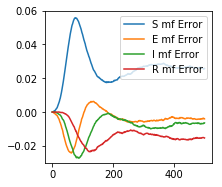

In [9]:
f = plt.figure()
f.set_size_inches(3,2.8)
for i in range(4):
    plt.plot(Msimu[:,i]-M[:,i])
plt.ylim([-0.03,0.06])
plt.legend(['{} mf Error'.format(i) for i in ['S','E','I','R']],loc='upper right')
f.savefig('SEIR_errorMF_N10.pdf',bbox_inches='tight')

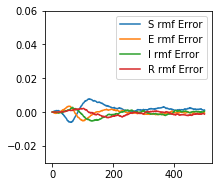

In [10]:
f = plt.figure()
f.set_size_inches(3,2.8)
for i in range(4):
    plt.plot(Msimu[:,i]-M[:,i]-V[:,i]/N)
plt.ylim([-0.03,0.06])
plt.legend(['{} rmf Error'.format(i) for i in ['S','E','I','R']],loc='upper right')
f.savefig('SEIR_errorRMF_N10.pdf',bbox_inches='tight')